In [3]:
# Setup to analyse an MDP Playground experiment
from mdp_playground.analysis import MDPP_Analysis
# Set dir_name to the location where the CSV files from running an experiment were saved
dir_name = '/home/rajanr/mdpp_12729986'
# 12348452, 12354801, 12362352, 12495380, 12499228, 12500667, 12503823, 12505701, 12506870, 12532831, 12536403, 12540214, 12546339, 12550729, 12552121, 12578498, 12578770, 12579037, 12579179, 12579254, 12579419,
# DDPG 12634504, 12678295, 12680567, 12699005, 12699367, 12699450, 12699786, 12700125, 12700943, 12701301, 12702414, 12703211, 12703537, 12703863, 12704353, 12705180, 12705480, 12713180
# TD3 12706334, 12707024, 12707717, 12712031, 12712470, 12713006, 12713385, 12715696
# Set exp_name to the name that was given to the experiment when running it
exp_name = 'sac_move_to_a_point_tune_hps'
num_total_configs = 243
# Set the following to True to save PDFs of plots that you generate below
save_fig = True

In [4]:
# Data loading
mdpp_analysis = MDPP_Analysis()
train_stats, eval_stats, train_curves, eval_curves = mdpp_analysis.load_data(dir_name, exp_name, max_total_configs=num_total_configs)

Loading data from a distributed run of experiment configurations. Creating a combined CSV stats file.
243 files were combined into 1 for file:/home/rajanr/mdpp_12729986/sac_move_to_a_point_tune_hps_n.csv
Files missing for config_nums: [] . Did you pass the right value for max_total_configs as an argument?
Unique line count values: [20]
243 files were combined into 1 for file:/home/rajanr/mdpp_12729986/sac_move_to_a_point_tune_hps_n_eval.csv
Files missing for config_nums: [] . Did you pass the right value for max_total_configs as an argument?
Unique line count values: [209]
Training stats read (rows, columns): (4617, 24)
train stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3)
eval stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3)
Dimension varied: dummy_seed . The values it took: ['0', '1', '2'] . Number of values it took: 3 . Index in loaded data: 13
Dimension varied: critic_learning_rate . The values it took: ['0.003', '0.0003', '2

TypeError: only size-1 arrays can be converted to Python scalars

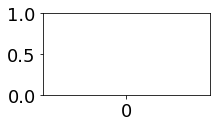

In [5]:
# 1-D: Plots showing reward after 20k timesteps when varying a single meta-feature
# Plots across 10 runs: Training: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(train_stats, save_fig, metric_num=-2)

In [ ]:
# Plots across 10 runs: Evaluation: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(eval_stats, save_fig, train=False, metric_num=-2)

In [ ]:
mdpp_analysis.plot_1d_dimensions(train_stats, save_fig, metric_num=-1)

In [ ]:
mdpp_analysis.plot_1d_dimensions(eval_stats, save_fig, train=False, metric_num=-1)

In [ ]:
# 2-D heatmap plots across 10 runs: Training runs: with std dev across the runs
# There seems to be a bug with matplotlib - x and y axes tick labels are not correctly set even though we pass them. Please feel free to look into the code and suggest a correction if you find it.
mdpp_analysis.plot_2d_heatmap(train_stats, save_fig, metric_num=-2)

In [ ]:
# 2-D heatmap plots across 10 runs: Evaluation runs: with std dev across the runs
mdpp_analysis.plot_2d_heatmap(eval_stats, save_fig, train=False, metric_num=-2)

In [ ]:
# Plot learning curves: Training: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(train_curves, save_fig, metric_num=-2)

In [ ]:
# Plot learning curves: Evaluation: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(eval_curves, save_fig, train=False)

config_file_path: /home/rajanr/mdp-playground/experiments
Number of seeds for environment: 3
Found seed axis: dummy_seed
value_tuples [[2], [2], [0], [True], [0], [0], [[0, 0]], [0.5], [10], [1], [1.0], [1], [0.003, 0.0003, 3e-05], [[8, 8], [16, 16], [32, 32]], [0.1, 1.0, 10.0], [0.02, 0.002, 0.0002], [2000], [1]]
Total number of configs. to run: 81
Varying dims: ['dummy_seed', 'critic_learning_rate', 'fcnet_hiddens', 'initial_alpha', 'tau']
dummy_seeds_axis: 13 21
Sliced shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1) (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1)
sort of indices:
 [40 53 10  9 34 47 44 19 64 20 42 21 43 22 37 14 38 23 11  5 18  6 65 25
  2 77 51 32 13 28 73  4 33 29 74 46 72  1 39  0 48 52 75 41 26  8 17 27
  3 45 15 24 36 49  7 50 63 68 66 56 12 31 30 67 16 76 35 54 58 80 79 69
 78 61 70 59 60 71 55 57 62]
sort of indices (with std taken into account):
 [47  9 34 10 64 53 20 11 23 19 44 40 14 22 43 21 37  5 42 38 65 18 25 51
  1 77 33 

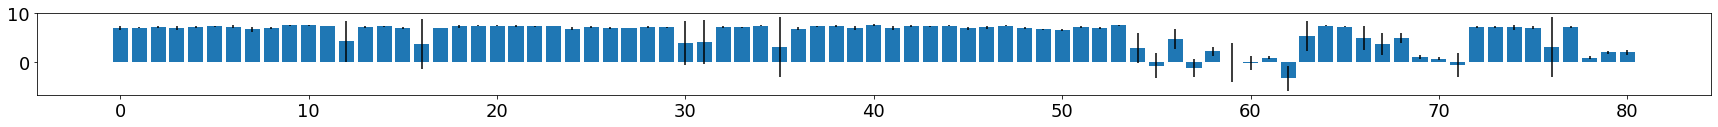

Sliced shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1) (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1)
sort of indices:
 [44 74 53 73 15 18 40 21 29 37 32  7  9 28 41 46 13  0 48 10 34 49 33 22
 24 45 77  2 75  6  4  1 25 14 17  8 20 26 65 11 23 19 64 38 72  5 50 47
 36  3 39 42 43 27 63 51 68 52 67 66 79 80 56 12 30 31 58 54 76 35 78 16
 69 59 70 57 61 71 55 60 62]
sort of indices (with std taken into account):
 [44 74 53 73 15 37 18 13 28 29  7 21  9 32 40 22 10 48 77 46 75 49 20 14
 11  2  0 24 25 33 17 34 26 19 41  8  4  6 23 38  1 45 50 65 47  5 64 36
 72  3 42 43 39 27 52 51 63 68 67 79 80 66 56 78 69 70 12 58 30 54 31 61
 76 55 60 35 16 59 71 57 62]
sort of values:
 [ 7.42984765  7.42156128  7.39526137  7.36599323  7.31772286  7.31083597
  7.30540037  7.30080235  7.29803345  7.29545482  7.28832414  7.27791257
  7.26174428  7.25923457  7.258582    7.25766582  7.2567923   7.2526305
  7.24668705  7.24425629  7.24212553  7.23531096  7.23241503  7.230488

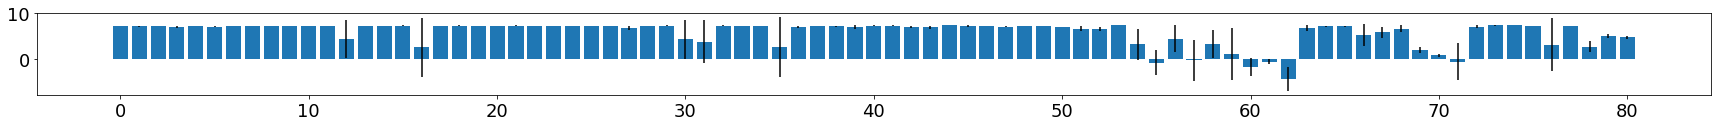

SpearmanrResult(correlation=0.7029358626919602, pvalue=2.5669822337450436e-13)
SpearmanrResult(correlation=0.9671409214092139, pvalue=9.556116191452366e-49)
SpearmanrResult(correlation=0.7120596205962059, pvalue=9.133019650740677e-14)
SpearmanrResult(correlation=0.9690831074977416, pvalue=8.937367990028564e-50)


In [7]:
# some more analysis
import os
import sys
import numpy as np
from scipy.stats import spearmanr as spm
from scipy.stats import pearsonr as prs
import matplotlib.pyplot as plt

dir_name_config = 'experiments/'
file_ = dir_name_config + exp_name

config_file_path = os.path.abspath('/'.join(file_.split('/')[:-1]))
# print(file_.split('/')[:-1])
print("config_file_path:", config_file_path)
sys.path.insert(1, config_file_path) #hack
import importlib
config = importlib.import_module(file_.split('/')[-1], package=None)
print("Number of seeds for environment:", config.num_seeds)

value_tuples = []
for config_type, config_dict in config.var_configs.items():
    for key in config_dict:
        if 'seed' in key:
            print("Found seed axis:", key)
            pass
        else:
            assert type(config.var_configs[config_type][key]) == list, "var_config should be a dict of dicts with lists as the leaf values to allow each configuration option to take multiple possible values"
            value_tuples.append(config.var_configs[config_type][key])
print("value_tuples", value_tuples)

import itertools
cartesian_product_configs = list(itertools.product(*value_tuples))
print("Total number of configs. to run:", len(cartesian_product_configs))
print("Varying dims:", mdpp_analysis.axis_labels)
# import itertools
# cartesian_product_configs = list(itertools.product(*config_vals))
for i in range(len(train_stats.shape)):
    if train_stats.shape[i] > 1:
        dummy_seeds_axis = i
        break
print("dummy_seeds_axis:", dummy_seeds_axis, len(train_stats.shape))


def analysis(train_stats):
    mean_data_ = np.mean(train_stats[..., -2], axis=dummy_seeds_axis)
    std_data_ = np.std(train_stats[..., -2], axis=dummy_seeds_axis)
    print("Mean shape (after slice), Sliced shape:", mean_data_.shape, train_stats[..., -2].shape)
    flattened_mean = np.ravel(mean_data_)
    flattened_std = np.ravel(std_data_)
    ranks = np.argsort(flattened_mean)[::-1]
    print('sort of indices:\n', ranks)
    ranks_with_std = np.argsort(flattened_mean - flattened_std)[::-1]
    print('sort of indices (with std taken into account):\n', ranks_with_std)
    sorted_vals = np.sort(flattened_mean)[::-1]
    print('sort of values:\n', sorted_vals)
    sorted_vals_with_std = np.sort(flattened_mean - flattened_std)[::-1]
    print('sort of values (with std taken into account):\n', sorted_vals_with_std)
    print("TOP 3 configs (with std taken into account):")
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-1]]) 
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-2]])
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-3]])
    print("\nBOTTOM 3 configs (with std taken into account):")
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[0]]) 
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[1]])
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[2]])
    plt.figure(figsize=(30, 1.5))
    plt.bar([i for i in range(len(flattened_mean))], flattened_mean, yerr=flattened_std)
    plt.show()
    return flattened_mean, flattened_mean - flattened_std
    
sorted_vals_t, sorted_vals_with_std_t = analysis(train_stats)
sorted_vals_e, sorted_vals_with_std_e = analysis(eval_stats)
print(spm(sorted_vals_t, sorted_vals_e))
print(spm(sorted_vals_t, sorted_vals_with_std_t))
print(spm(sorted_vals_with_std_t, sorted_vals_with_std_e))
print(spm(sorted_vals_e, sorted_vals_with_std_e))
